<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/interferometro_michelson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import scipy.constants as cost
import os

try:
  from uncertainties import unumpy
except ModuleNotFoundError:
  os.system("pip install uncertainties")
  from uncertainties import unumpy
  
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['axes.facecolor'] = '#f7f9fc'

In [13]:
path = "https://www.dropbox.com/s/hcbw9p2c8utgwdq/Dati_Michelson-v4.xlsx?dl=1"
# inserisco i dati in un dataset pandas.
data = pd.read_excel(path, names=[
    "dl", "vmax", "svmax", "vmin", "svmin"
  ]
)
data['sdl'] = 0.1 # 1mm uncertainty on lengths
data['tau'] = data['dl']*2/29.98 # [ns]
data['stau'] = data['sdl']*2/29.98 # [ns]
vmax = unumpy.uarray(data.vmax, data.svmax)
vmin = unumpy.uarray(data.vmin, data.svmin)
tau = unumpy.uarray(data.tau, data.stau)

vis = (vmax - vmin) / (vmax + vmin) # automatically evaluates uncertainties
data['vis'] = unumpy.nominal_values(vis)
data['svis'] = unumpy.std_devs(vis)
data.head()

,dl,vmax,svmax,vmin,svmin,sdl,tau,stau,vis,svis
0,-5.1,77.2,3.3,9.0,1.3,0.1,-0.340227,0.006671,0.791183,0.028171
1,-2.5,113.4,4.4,7.4,1.2,0.1,-0.166778,0.006671,0.877483,0.019177
2,0.0,79.4,3.4,0.2,1.0,0.1,0.000000,0.006671,0.994975,0.025063
3,2.5,59.4,2.8,2.7,1.1,0.1,0.166778,0.006671,0.913043,0.034113
4,5.0,87.4,3.6,8.2,1.2,0.1,0.333556,0.006671,0.828452,0.023843


In [0]:
import scipy.odr as odr
from scipy.stats import kstest

''' Performs the fit
Needed Parameters (key-word):
  function: function with 2 arguments:
    array-like object for parameters (float-like)
    array-like object for variables (float-like)
  par0: array-like object for parameters prior (float-like)
  par_names: array-like object for parameters prior (string)
  file_name: csv with data
Returns:
  tuple with array of parameters and pvalue
'''
def fit(function=None, par0=None, par_names=None,
        x=None, y=None, sx=None, sy=None,
        xlabel="", ylabel="", title="", xres = 100, ax1=None, ax2=None):

  fit_data = odr.RealData(x, y=y, sx=sx, sy=sy)
  model = odr.Model(function)
  fit = odr.ODR(fit_data, 
                model, 
                beta0=par0)
  out = fit.run()

  par = out.beta
  par_s = out.sd_beta
  for i in range(len(par_names)):
    print(f'{par_names[i]} : {par[i]:.3f} +- {par_s[i]:.3f}')

  ax1.errorbar(x, y, xerr=sx, yerr=sy,
    ecolor='black', fmt='o', color='black', markersize=2
  )
  d_x = max(x)-min(x)
  x = np.linspace(min(x)-d_x/10, max(x)+d_x/10, xres)
  d_y = max(y)-min(y)
  ax1.set_ylim(min(y)-d_y/10, max(y)+d_y/10)
  ax1.plot(x, function(par, x), color='blue')
  ax1.set(xlabel=xlabel, ylabel=ylabel, title=title)
  '''
  kolmogorov-smirnov test on normalized residuals is performed
  it tests the similarity between normalized residuals and a normalized gaussian
  this similarity implies a reasonable belief in goodnes of fit and
  correct estimation of uncertainties
  if pvalue is > 0.05 the fit is accepted
  '''
  y_res_norm = out.eps/sy
  ax2.hist(y_res_norm)
  ax2.set_title("Residuals histogram")
  pvalue = kstest(y_res_norm, 'norm').pvalue
  print(f"p_value: {pvalue:.3f}")
  return out

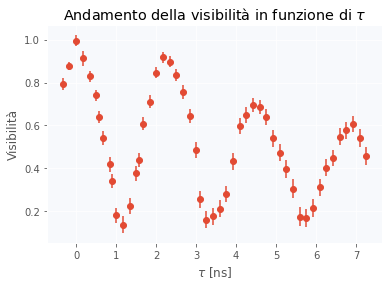

In [15]:
fig, ax = plt.subplots()
ax.set(title=r'Andamento della visibilità in funzione di $\tau$',
     ylabel = 'Visibilità', xlabel = r'$\tau$ [ns]')
ax.errorbar(data.tau, data.vis, xerr=data.stau, yerr=data.svis, fmt="o")
plt.show()
fig.savefig("vis.png")

sigma : 0.149 +- 0.009
Domega : 2.748 +- 0.011
p_value: 0.222


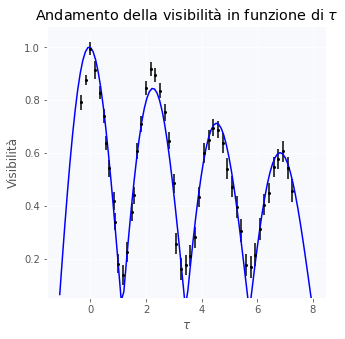

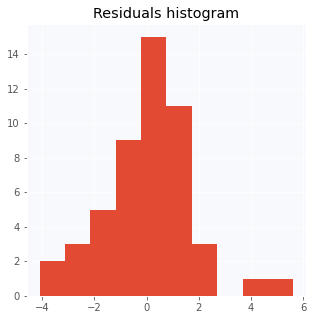

In [35]:
def vis(N=2):
  def func(par, t):
      sigma, Domega = par
      y = np.exp(-sigma*t/2)/N * \
        np.abs(
            np.sin(N*Domega*t/2) / \
              (np.sin(Domega*t/2)+1e-10) # for unmerical stability
        )
      return y
  return func
fig1, ax1 = plt.subplots(figsize=(5, 5))
fig2, ax2 = plt.subplots(figsize=(5, 5))
out = fit(vis(), x = data.tau, y = data.vis, sy = data.svis, sx = data.stau,
    par0 = [0.16, 2.7], par_names=['sigma', 'Domega'],
    ax1=ax1, ax2=ax2, xlabel=r"$\tau$", ylabel="Visibilità", 
    title=r'Andamento della visibilità in funzione di $\tau$')
fig1.savefig("fitn2.png")

In [17]:
  par = out.beta
  par_s = out.sd_beta
  tc = 2/par[0]
  stc = par_s[0]/(par[0]**2)
  print(f'Coerence Time: ({tc :.1f} +/- {stc:.1f}) ns')

Coerence Time: (13.5 +/- 0.4) ns


In [18]:
# lunghezza della cavità
L = cost.pi*cost.c/(par[1]*1e7)
sL = cost.pi*cost.c*par_s[1]*1e7/(par[1]*1e7)**2
print(f'Lunghezza della cavità del laser: ({L:.3f} +- {sL:.3f}) cm')

Lunghezza della cavità del laser: (34.278 +- 0.140) cm


sigma : 0.086 +- 0.029
Domega : 2.741 +- 0.021
p_value: 0.000


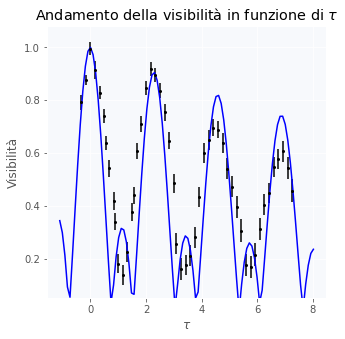

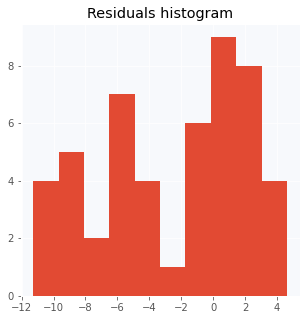

In [0]:
#verifica dell'ipotesi dei 3 modi
fig1, ax1 = plt.subplots( figsize=(5, 5))
fig2, ax2 = plt.subplots(figsize=(5, 5))

out = fit(vis(N=3), x = data.tau, y = data.vis, sy = data.svis, sx = data.stau,
    par0 = [0.16, 2.7], par_names=['sigma', 'Domega'],
    ax1=ax1, ax2=ax2, xlabel=r"$\tau$", ylabel="Visibilità", 
    title=r'Andamento della visibilità in funzione di $\tau$')

fig1.savefig("fitn3.png")

Supponendo $I_2 = \alpha \, I_2$, si ha $|\gamma_{12}| = \frac{2\sqrt{\alpha}}{1+\alpha}|\gamma_{11}|$. Dunque si può trovare $\alpha$ da $A=|\gamma_{12}(\tau = 0)|^2 $ risolvendo un'equazione di secondo grado: <br>
$\alpha = \frac{2-A-2\sqrt{1-A}}{A}$

0.8+/-0.4


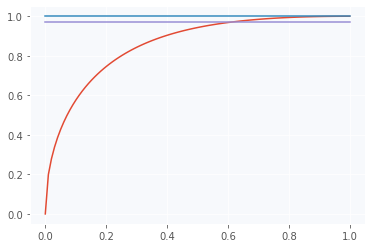

In [59]:
# massimo della visibilità
from uncertainties import ufloat, umath
A = ufloat(data.vis[data.tau==0].values[0], data.svis[data.tau==0].values[0])**2
alpha = (2-A-2*umath.sqrt(1-A))/A
print(alpha)
x = np.linspace(0, 1, 100)
plt.plot(x, 2*np.sqrt(x)/(1+x))
plt.plot(x, 1*np.ones(x.shape))
plt.plot(x, (0.995-0.025)*np.ones(x.shape))